0. 필요한 라이브러리 및 모듈 불러오기

In [1]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator 

import torch
import torch.optim as optim
import torch.nn as nn
from torchtext.vocab import Vocab
import pandas as pd
import os
import importlib.util
import pickle

# 모듈을 동적으로 불러오는 함수
def load_module_from_path(path):
    module_name = os.path.splitext(os.path.basename(path))[0]
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# 파일 경로 설정
preProcessing_path = "preProcessing/raiting.py"
attention_path = "model_class/Attention.py"
lstm_path = "model_class/LSTMModel.py"
dataset_path = "model_class/ReviewDataset.py"

# 각 파일 모듈 불러오기
preProcessing = load_module_from_path(preProcessing_path)
Attention = load_module_from_path(attention_path)
LSTMModel = load_module_from_path(lstm_path)
ReviewDataset = load_module_from_path(dataset_path)

# kaggle 넷플릭스 리뷰
data = pd.read_csv("data/netflix_reviews.csv")

/opt/anaconda3/envs/dipLearning/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/dipLearning/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/dipLearning/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORT

1. 데이터 불러오기 및 시각화

In [3]:
data

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,4f8e23e8-860d-4cf2-8a07-0735e9e94dac,Eddy Wijaya,Can't open,1,0,NaN,2024-10-19 14:23:00,NaN
1,b36f1a48-1ac6-4dc0-a895-50a520205fef,Tirthesh Poojari,The best app😍😍😍😍😍😍😍😍😍😍😍😍😍,5,0,NaN,2024-10-19 14:17:36,NaN
2,61ec00cf-0ced-4d96-98b5-b67cde1d4c83,Trupti Ambade,Most of the famous Korean drama are not dubbed...,2,0,8.136.0 build 3 50908,2024-10-19 14:17:18,8.136.0 build 3 50908
3,1a05f4ef-ff9e-46cb-948b-4bd3a27d5d53,Sanju Sahu,It's superb but can you please add comments se...,5,0,8.136.0 build 3 50908,2024-10-19 14:16:43,8.136.0 build 3 50908
4,cb98f179-4996-445e-a896-f49313a8c84b,Billy Barras,The only reason I didn't give it four stars is...,1,0,8.136.0 build 3 50908,2024-10-19 14:16:20,8.136.0 build 3 50908
...,...,...,...,...,...,...,...,...
116926,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
116927,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
116928,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
116929,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


In [4]:
data.columns

Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')

In [5]:
data.shape

(116931, 8)

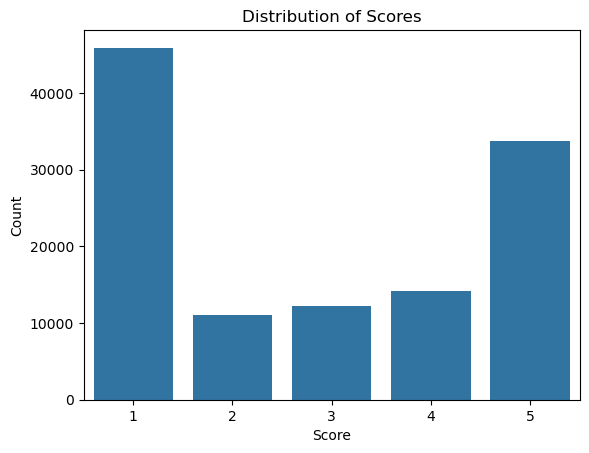

In [6]:
num_of_review=data['score'].value_counts()
import seaborn as sns 
import matplotlib.pyplot as plt  

sns.barplot(x=num_of_review.index, y=num_of_review.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

2. 함수 불러오기 및 파이프 파인 함수 정의

In [9]:
train_reviews, test_reviews, train_ratings, test_ratings = preProcessing.getSplitReviewsAndRaitings(data)
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(preProcessing.yield_tokens(train_reviews, tokenizer), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

def text_pipeline(text):
    return [vocab[token] for token in tokenizer(text)]

def label_pipeline(label):
    return int(label)-1

2-2. 데이터 셋의 문장에 단어집 변환 파이프 라인 및 score 인덱스 화 진행

In [11]:
train_dataset = ReviewDataset.ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset.ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

2-3. 문장의 가변 길이에 따른 패딩 조절

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    reviews, raitings = [], []
    
    for review, raiting in batch:
        reviews.append(torch.tensor(review, dtype=torch.long))
        raitings.append(torch.tensor(raiting, dtype=torch.long))

    # padding을 주어 짧은 문장에 대한 길이를 맞춥니다.
    padded_reviews = pad_sequence(reviews, batch_first=True, padding_value=0)
    
    return padded_reviews, torch.tensor(raitings, dtype=torch.long)

2-4. 배치사이즈에 따른 데이터 로더 불러오기

In [13]:
# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

3. Attention 알고리즘 적용된 기본 LSTM 모델 불러오기

In [14]:
# 하이퍼파라미터 수정
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64  
HIDDEN_DIM = 128  
OUTPUT_DIM = 3
NUM_EPOCHS = 100
LABEL_SMOOTHING = 0.05

model =  LSTMModel.LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)


# 손실 함수와 옵티마이저 정의
# 라벨 스무딩을 이용하여 모델의 일반화 성능을 향상시킴 (평점이 리뷰와 안맞는 케이스 완화)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=0.01)

4. 학습 진행

In [41]:
# 학습 루프 개선
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for reviews, ratings in tqdm.tqdm(train_dataloader):
        outputs = model(reviews)
        optimizer.zero_grad()
        loss = criterion(outputs, ratings)  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{100}], Loss: {running_loss / len(train_dataloader):.4f}')
        

print('Finished Training')

  0%|                                                  | 0/1462 [00:00<?, ?it/s]/var/folders/jd/z3tj001966qd1b1w4_jn3_zr0000gn/T/ipykernel_4031/4066590696.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reviews.append(torch.tensor(truncated_review, dtype=torch.long))
/var/folders/jd/z3tj001966qd1b1w4_jn3_zr0000gn/T/ipykernel_4031/4066590696.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raitings.append(torch.tensor(raiting, dtype=torch.long))
100%|███████████████████████████████████████| 1462/1462 [18:03<00:00,  1.35it/s]


Epoch [1/100], Loss: 0.8553


100%|███████████████████████████████████████| 1462/1462 [18:05<00:00,  1.35it/s]


Epoch [2/100], Loss: 0.8399


100%|█████████████████████████████████████| 1462/1462 [1:13:21<00:00,  3.01s/it]


Epoch [3/100], Loss: 0.8393


100%|███████████████████████████████████████| 1462/1462 [12:05<00:00,  2.02it/s]


Epoch [4/100], Loss: 0.8276


100%|███████████████████████████████████████| 1462/1462 [12:25<00:00,  1.96it/s]


Epoch [5/100], Loss: 0.8025


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [6/100], Loss: 0.7982


100%|███████████████████████████████████████| 1462/1462 [12:13<00:00,  1.99it/s]


Epoch [7/100], Loss: 0.8027


100%|███████████████████████████████████████| 1462/1462 [46:34<00:00,  1.91s/it]


Epoch [8/100], Loss: 0.7898


100%|███████████████████████████████████████| 1462/1462 [19:41<00:00,  1.24it/s]


Epoch [9/100], Loss: 0.7951


100%|███████████████████████████████████████| 1462/1462 [28:36<00:00,  1.17s/it]


Epoch [10/100], Loss: 0.7936


100%|█████████████████████████████████████| 1462/1462 [9:22:39<00:00, 23.09s/it]


Epoch [11/100], Loss: 0.7789


100%|█████████████████████████████████████| 1462/1462 [6:41:20<00:00, 16.47s/it]


Epoch [12/100], Loss: 0.7636


100%|███████████████████████████████████████| 1462/1462 [14:03<00:00,  1.73it/s]


Epoch [13/100], Loss: 0.7549


100%|███████████████████████████████████████| 1462/1462 [14:11<00:00,  1.72it/s]


Epoch [14/100], Loss: 0.7499


100%|█████████████████████████████████████| 1462/1462 [4:15:44<00:00, 10.50s/it]


Epoch [15/100], Loss: 0.7503


100%|█████████████████████████████████████| 1462/1462 [2:51:15<00:00,  7.03s/it]


Epoch [16/100], Loss: 0.7523


100%|███████████████████████████████████████| 1462/1462 [17:53<00:00,  1.36it/s]


Epoch [17/100], Loss: 0.7550


100%|███████████████████████████████████████| 1462/1462 [13:33<00:00,  1.80it/s]


Epoch [18/100], Loss: 0.7501


100%|███████████████████████████████████████| 1462/1462 [13:50<00:00,  1.76it/s]


Epoch [19/100], Loss: 0.7690


100%|███████████████████████████████████████| 1462/1462 [12:43<00:00,  1.91it/s]


Epoch [20/100], Loss: 0.7583


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [21/100], Loss: 0.7480


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [22/100], Loss: 0.7335


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [23/100], Loss: 0.7289


100%|███████████████████████████████████████| 1462/1462 [12:12<00:00,  1.99it/s]


Epoch [24/100], Loss: 0.7255


100%|███████████████████████████████████████| 1462/1462 [12:28<00:00,  1.95it/s]


Epoch [25/100], Loss: 0.7315


100%|███████████████████████████████████████| 1462/1462 [15:13<00:00,  1.60it/s]


Epoch [26/100], Loss: 0.7466


100%|███████████████████████████████████████| 1462/1462 [12:50<00:00,  1.90it/s]


Epoch [27/100], Loss: 0.7551


100%|███████████████████████████████████████| 1462/1462 [12:25<00:00,  1.96it/s]


Epoch [28/100], Loss: 0.7362


100%|███████████████████████████████████████| 1462/1462 [12:11<00:00,  2.00it/s]


Epoch [29/100], Loss: 0.7246


100%|███████████████████████████████████████| 1462/1462 [12:37<00:00,  1.93it/s]


Epoch [30/100], Loss: 0.7140


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [31/100], Loss: 0.7156


100%|███████████████████████████████████████| 1462/1462 [12:18<00:00,  1.98it/s]


Epoch [32/100], Loss: 0.7161


100%|███████████████████████████████████████| 1462/1462 [12:51<00:00,  1.89it/s]


Epoch [33/100], Loss: 0.7135


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [34/100], Loss: 0.7180


100%|███████████████████████████████████████| 1462/1462 [12:58<00:00,  1.88it/s]


Epoch [35/100], Loss: 0.7207


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [36/100], Loss: 0.7325


100%|███████████████████████████████████████| 1462/1462 [12:22<00:00,  1.97it/s]


Epoch [37/100], Loss: 0.7261


100%|███████████████████████████████████████| 1462/1462 [12:31<00:00,  1.95it/s]


Epoch [38/100], Loss: 0.7075


100%|███████████████████████████████████████| 1462/1462 [12:31<00:00,  1.95it/s]


Epoch [39/100], Loss: 0.7030


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [40/100], Loss: 0.7074


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [41/100], Loss: 0.7048


100%|███████████████████████████████████████| 1462/1462 [12:35<00:00,  1.93it/s]


Epoch [42/100], Loss: 0.6974


100%|███████████████████████████████████████| 1462/1462 [12:33<00:00,  1.94it/s]


Epoch [43/100], Loss: 0.6940


100%|███████████████████████████████████████| 1462/1462 [12:35<00:00,  1.93it/s]


Epoch [44/100], Loss: 0.6973


100%|███████████████████████████████████████| 1462/1462 [12:30<00:00,  1.95it/s]


Epoch [45/100], Loss: 0.7024


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [46/100], Loss: 0.7105


100%|███████████████████████████████████████| 1462/1462 [12:27<00:00,  1.96it/s]


Epoch [47/100], Loss: 0.7076


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [48/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:39<00:00,  1.93it/s]


Epoch [49/100], Loss: 0.6845


100%|███████████████████████████████████████| 1462/1462 [12:39<00:00,  1.93it/s]


Epoch [50/100], Loss: 0.6843


100%|███████████████████████████████████████| 1462/1462 [12:29<00:00,  1.95it/s]


Epoch [51/100], Loss: 0.6908


100%|███████████████████████████████████████| 1462/1462 [12:18<00:00,  1.98it/s]


Epoch [52/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:28<00:00,  1.95it/s]


Epoch [53/100], Loss: 0.6959


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [54/100], Loss: 0.6979


100%|███████████████████████████████████████| 1462/1462 [12:27<00:00,  1.96it/s]


Epoch [55/100], Loss: 0.7022


100%|███████████████████████████████████████| 1462/1462 [12:26<00:00,  1.96it/s]


Epoch [56/100], Loss: 0.7007


100%|███████████████████████████████████████| 1462/1462 [12:33<00:00,  1.94it/s]


Epoch [57/100], Loss: 0.6945


100%|███████████████████████████████████████| 1462/1462 [12:23<00:00,  1.97it/s]


Epoch [58/100], Loss: 0.6944


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [59/100], Loss: 0.7015


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [60/100], Loss: 0.6982


100%|███████████████████████████████████████| 1462/1462 [34:38<00:00,  1.42s/it]


Epoch [61/100], Loss: 0.6983


100%|█████████████████████████████████████| 1462/1462 [5:04:21<00:00, 12.49s/it]


Epoch [62/100], Loss: 0.6996


100%|███████████████████████████████████████| 1462/1462 [14:49<00:00,  1.64it/s]


Epoch [63/100], Loss: 0.6901


100%|███████████████████████████████████████| 1462/1462 [15:28<00:00,  1.57it/s]


Epoch [64/100], Loss: 0.6901


100%|█████████████████████████████████████| 1462/1462 [1:15:14<00:00,  3.09s/it]


Epoch [65/100], Loss: 0.6864


100%|███████████████████████████████████████| 1462/1462 [14:15<00:00,  1.71it/s]


Epoch [66/100], Loss: 0.6868


100%|███████████████████████████████████████| 1462/1462 [19:18<00:00,  1.26it/s]


Epoch [67/100], Loss: 0.6867


100%|███████████████████████████████████████| 1462/1462 [14:22<00:00,  1.69it/s]


Epoch [68/100], Loss: 0.6882


100%|███████████████████████████████████████| 1462/1462 [15:40<00:00,  1.55it/s]


Epoch [69/100], Loss: 0.6834


100%|███████████████████████████████████████| 1462/1462 [14:33<00:00,  1.67it/s]


Epoch [70/100], Loss: 0.6753


100%|███████████████████████████████████████| 1462/1462 [14:49<00:00,  1.64it/s]


Epoch [71/100], Loss: 0.6666


100%|███████████████████████████████████████| 1462/1462 [14:03<00:00,  1.73it/s]


Epoch [72/100], Loss: 0.6667


100%|███████████████████████████████████████| 1462/1462 [13:38<00:00,  1.79it/s]


Epoch [73/100], Loss: 0.6669


100%|███████████████████████████████████████| 1462/1462 [12:43<00:00,  1.92it/s]


Epoch [74/100], Loss: 0.6672


100%|███████████████████████████████████████| 1462/1462 [12:24<00:00,  1.96it/s]


Epoch [75/100], Loss: 0.6714


100%|███████████████████████████████████████| 1462/1462 [12:41<00:00,  1.92it/s]


Epoch [76/100], Loss: 0.6737


100%|███████████████████████████████████████| 1462/1462 [13:26<00:00,  1.81it/s]


Epoch [77/100], Loss: 0.6765


100%|███████████████████████████████████████| 1462/1462 [12:48<00:00,  1.90it/s]


Epoch [78/100], Loss: 0.6791


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [79/100], Loss: 0.6820


100%|███████████████████████████████████████| 1462/1462 [12:42<00:00,  1.92it/s]


Epoch [80/100], Loss: 0.6858


100%|███████████████████████████████████████| 1462/1462 [12:40<00:00,  1.92it/s]


Epoch [81/100], Loss: 0.6855


100%|███████████████████████████████████████| 1462/1462 [12:48<00:00,  1.90it/s]


Epoch [82/100], Loss: 0.6797


100%|███████████████████████████████████████| 1462/1462 [13:14<00:00,  1.84it/s]


Epoch [83/100], Loss: 0.6752


100%|███████████████████████████████████████| 1462/1462 [13:20<00:00,  1.83it/s]


Epoch [84/100], Loss: 0.6754


100%|███████████████████████████████████████| 1462/1462 [14:08<00:00,  1.72it/s]


Epoch [85/100], Loss: 0.6782


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [86/100], Loss: 0.6789


100%|███████████████████████████████████████| 1462/1462 [12:54<00:00,  1.89it/s]


Epoch [87/100], Loss: 0.6806


100%|███████████████████████████████████████| 1462/1462 [12:52<00:00,  1.89it/s]


Epoch [88/100], Loss: 0.6796


100%|███████████████████████████████████████| 1462/1462 [12:49<00:00,  1.90it/s]


Epoch [89/100], Loss: 0.6781


100%|███████████████████████████████████████| 1462/1462 [12:46<00:00,  1.91it/s]


Epoch [90/100], Loss: 0.6809


100%|███████████████████████████████████████| 1462/1462 [12:50<00:00,  1.90it/s]


Epoch [91/100], Loss: 0.6757


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [92/100], Loss: 0.6760


100%|███████████████████████████████████████| 1462/1462 [13:58<00:00,  1.74it/s]


Epoch [93/100], Loss: 0.6750


100%|███████████████████████████████████████| 1462/1462 [12:54<00:00,  1.89it/s]


Epoch [94/100], Loss: 0.6749


100%|███████████████████████████████████████| 1462/1462 [16:05<00:00,  1.51it/s]


Epoch [95/100], Loss: 0.6738


100%|███████████████████████████████████████| 1462/1462 [12:56<00:00,  1.88it/s]


Epoch [96/100], Loss: 0.6737


100%|███████████████████████████████████████| 1462/1462 [14:20<00:00,  1.70it/s]


Epoch [97/100], Loss: 0.6789


100%|███████████████████████████████████████| 1462/1462 [14:22<00:00,  1.69it/s]


Epoch [98/100], Loss: 0.6704


100%|███████████████████████████████████████| 1462/1462 [13:02<00:00,  1.87it/s]


Epoch [99/100], Loss: 0.6663


100%|███████████████████████████████████████| 1462/1462 [13:09<00:00,  1.85it/s]

Epoch [100/100], Loss: 0.6655
Finished Training


5. 예측 함수 정의

In [42]:
# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review), dtype=torch.long).unsqueeze(0)
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return prediction + 1

예측 진행

In [44]:
# 새로운 리뷰에 대한 예측
new_review = "I hate this app."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 1


In [45]:
# 새로운 리뷰에 대한 예측
new_review = "I love the diversity of lanugauge of this app."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 5


In [46]:
new_review = "So Great"
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 5


In [53]:
new_review = "While Netflix has a lot of content, the app itself is frustrating to use. It frequently lags or freezes, especially when switching profiles or resuming a video, which makes watching anything feel like a hassle. The recommendation algorithm also seems off, constantly showing me shows I have no interest in despite my viewing history. For the price, I expected a more stable experience, but the app’s glitches and poor suggestions make it hard to fully enjoy. Hoping they fix these issues soon, but for now, it’s barely usable."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 3


In [54]:
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 4


In [57]:
new_review = "It was plain. Not impressed at all."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 1
